# Imports & Uploads

In [1]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Upload the excel file to your Drive and change the path below
file_path = '/content/drive/MyDrive/mmm/NIR_Data.xlsx'
df = pd.read_excel(file_path)

# Functions

In [4]:
# SNV function
def snv(input_data):
  return (input_data - np.mean(input_data, axis=1, keepdims=True)) / np.std(input_data, axis=1, keepdims=True)

In [5]:
# MSC function
def msc(input_data):
  # Mean center the data
  mean_spectrum = np.mean(input_data, axis=0)
  corrected_data = np.zeros_like(input_data)

  for i in range(input_data.shape[0]):
    fit = np.polyfit(mean_spectrum, input_data[i, :], 1, full=True)
    corrected_data[i, :] = (input_data[i, :] - fit[0][1]) / fit[0][0]

  return corrected_data

In [6]:
# Function for train-test split
def train_test_split_data(df, label):
  X = df.iloc[:, 2:-1].values  # Exclude non-spectral columns
  y = df['Moisture'].values    # Target variable

  # Split data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  print(f"{label}:")
  print(f"  Train Shape: X_train {X_train.shape}, y_train {y_train.shape}")
  print(f"  Test Shape: X_test {X_test.shape}, y_test {y_test.shape}")
  print('-' * 40)

  return X_train, X_test, y_train, y_test

In [7]:
# Function to perform CV, return RMSE & R² values, and find optimal components
def cross_validate_pls(X, y, max_components=30):
  rmse_values = []
  r2_values = []

  for n in range(1, max_components + 1):
    pls = PLSRegression(n_components=n)

    # RMSE Calculation
    rmse_scores = -cross_val_score(pls, X, y, cv=5, scoring='neg_root_mean_squared_error')
    rmse_values.append(np.mean(rmse_scores))

    # R² Calculation
    r2_scores = cross_val_score(pls, X, y, cv=5, scoring='r2')
    r2_values.append(np.mean(r2_scores))

  # Optimal components based on RMSE and R²
  optimal_rmse = np.argmin(rmse_values) + 1
  optimal_r2 = np.argmax(r2_values) + 1

  return rmse_values, r2_values, optimal_rmse, optimal_r2

In [8]:
# Function to train and evaluate PLS model
def train_evaluate_pls(X_train, y_train, X_test, y_test, optimal_components):
  pls = PLSRegression(n_components=optimal_components)
  pls.fit(X_train, y_train)

  # Predictions
  y_train_pred = pls.predict(X_train)
  y_test_pred = pls.predict(X_test)

  # Performance Metrics
  train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
  test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
  train_r2 = r2_score(y_train, y_train_pred)
  test_r2 = r2_score(y_test, y_test_pred)

  return train_rmse, test_rmse, train_r2, test_r2

In [9]:
# Function to visualize predicted vs actual values
def visualize_predictions(y_train, y_train_pred, y_test, y_test_pred, dataset_name):
  plt.figure(figsize=(12, 6))

  # Training set plot
  plt.subplot(1, 2, 1)
  plt.scatter(y_train, y_train_pred, alpha=0.6)
  plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
  plt.title(f'{dataset_name} - Training Set')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.grid(True)

  # Test set plot
  plt.subplot(1, 2, 2)
  plt.scatter(y_test, y_test_pred, alpha=0.6)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
  plt.title(f'{dataset_name} - Test Set')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.grid(True)

  plt.tight_layout()
  plt.show()

In [10]:
# Function to visualize residuals
def visualize_residuals(y_train, y_train_pred, y_test, y_test_pred, dataset_name):
  train_residuals = y_train - y_train_pred.flatten()
  test_residuals = y_test - y_test_pred.flatten()

  plt.figure(figsize=(12, 6))

  # Residuals - Training Set
  plt.subplot(1, 2, 1)
  plt.scatter(y_train, train_residuals, alpha=0.6)
  plt.axhline(0, color='red', linestyle='--')
  plt.title(f'{dataset_name} - Training Residuals')
  plt.xlabel('Actual Values')
  plt.ylabel('Residuals')
  plt.grid(True)

  # Residuals - Test Set
  plt.subplot(1, 2, 2)
  plt.scatter(y_test, test_residuals, alpha=0.6)
  plt.axhline(0, color='red', linestyle='--')
  plt.title(f'{dataset_name} - Test Residuals')
  plt.xlabel('Actual Values')
  plt.ylabel('Residuals')
  plt.grid(True)

  plt.tight_layout()
  plt.show()

In [11]:
# Function to perform hyperparameter tuning for SVR
def svr_cv(X_train, y_train):
  param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['linear', 'rbf']
  }

  svr = SVR()
  grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_root_mean_squared_error')
  grid_search.fit(X_train, y_train.ravel())

  best_params = grid_search.best_params_
  best_rmse = -grid_search.best_score_  # Convert back to positive RMSE

  return best_params, best_rmse

In [12]:
# Function to train and evaluate SVR
def train_evaluate_svr(X_train, y_train, X_test, y_test, best_params):
  svr = SVR(**best_params)
  svr.fit(X_train, y_train.ravel())

  # Predictions
  y_train_pred = svr.predict(X_train)
  y_test_pred = svr.predict(X_test)

  # Performance Metrics
  train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
  test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
  train_r2 = r2_score(y_train, y_train_pred)
  test_r2 = r2_score(y_test, y_test_pred)

  return train_rmse, test_rmse, train_r2, test_r2, y_train_pred, y_test_pred

In [13]:
# Function to build an ANN model
def build_ann(input_dim, learning_rate=0.001):
  model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dense(32, activation='relu'),
    Dense(1)
  ])

  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss='mean_squared_error',
                metrics=['mean_squared_error'])
  return model

In [14]:
# Function to train the ANN model
def train_ann(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
  early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

  history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stopping]
  )

  return history

In [15]:
# Function to calculate RMSE and R² for predictions
def calculate_metrics(y_true, y_pred):
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  r2 = r2_score(y_true, y_pred)
  return rmse, r2

# Data Analysis

In [16]:
df

,Sample ID,Unnamed: 1,11988.51,11980.8,11973.08,11965.37,11957.66,11949.94,11942.23,11934.51,...,4057.888,4050.173,4042.459,4034.744,4027.03,4019.315,4011.601,4003.886,3996.171,Moisture
0,3001RanBioMixMalarenergi.0,1,0.430391,0.430351,0.430570,0.430974,0.431129,0.430807,0.430425,0.430264,...,1.042346,1.052940,1.062511,1.070474,1.077419,1.082571,1.084933,1.086961,1.088756,24.933532
1,3001RanBioMixMalarenergi.1,2,0.418378,0.418387,0.418783,0.418983,0.418721,0.418339,0.417951,0.417494,...,1.017335,1.027128,1.036592,1.043992,1.049032,1.051711,1.052812,1.054065,1.055364,24.933532
2,3001RanBioMixMalarenergi.2,3,0.446782,0.446930,0.446840,0.446419,0.446009,0.445715,0.445539,0.445537,...,1.053265,1.061849,1.070649,1.079960,1.088810,1.094708,1.098719,1.100796,1.099144,24.933532
3,3001RanBioMixMalarenergi.3,4,0.434038,0.433805,0.433692,0.433850,0.433912,0.433757,0.433515,0.433327,...,1.020629,1.029372,1.038613,1.047470,1.053009,1.054695,1.054589,1.053924,1.053708,24.933532
4,3001RanBioMixMalarenergi.4,5,0.451491,0.451441,0.451692,0.451816,0.451755,0.451595,0.451293,0.451114,...,1.013404,1.023107,1.030855,1.036464,1.042622,1.049984,1.055300,1.055122,1.052386,24.933532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,3154RanBioMixMalarenergi.1,945,0.340521,0.340076,0.339782,0.339961,0.340233,0.340201,0.339958,0.339772,...,1.012959,1.023482,1.032525,1.040089,1.044798,1.047819,1.047905,1.046299,1.045034,39.039775
769,3154RanBioMixMalarenergi.2,946,0.369337,0.368663,0.367986,0.367705,0.367920,0.368156,0.368237,0.368364,...,0.958066,0.967192,0.973893,0.978803,0.982503,0.985984,0.987628,0.988656,0.987488,39.039775
770,3154RanBioMixMalarenergi.3,947,0.414796,0.414180,0.413598,0.413055,0.413093,0.413714,0.414176,0.414099,...,1.037804,1.047028,1.054885,1.060705,1.066238,1.071721,1.073868,1.073359,1.073496,39.039775
771,3154RanBioMixMalarenergi.4,948,0.353829,0.353229,0.352726,0.352591,0.352698,0.352684,0.352596,0.352764,...,1.089022,1.099540,1.110634,1.119961,1.126208,1.130563,1.136066,1.142062,1.143006,39.039775


In [17]:
# Check the data types
df.dtypes

,0
Sample ID,object
Unnamed: 1,int64
11988.51,float64
11980.8,float64
11973.08,float64
...,...
4019.315,float64
4011.601,float64
4003.886,float64
3996.171,float64


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Columns: 1040 entries, Sample ID to Moisture
dtypes: float64(1038), int64(1), object(1)
memory usage: 6.1+ MB


In [19]:
if df.isnull().values.any():
  print("There are missing values in the dataset.")
else:
  print("No missing values found.")

No missing values found.


In [20]:
df.describe()

,Unnamed: 1,11988.51,11980.8,11973.08,11965.37,11957.66,11949.94,11942.23,11934.51,11926.8,...,4057.888,4050.173,4042.459,4034.744,4027.03,4019.315,4011.601,4003.886,3996.171,Moisture
count,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,...,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000
mean,408.213454,0.555737,0.555510,0.555277,0.555048,0.554840,0.554626,0.554355,0.554071,0.553910,...,1.317717,1.329259,1.340147,1.350056,1.358602,1.366028,1.371983,1.376410,1.379461,45.923968
std,248.050920,0.175660,0.175460,0.175265,0.175117,0.174975,0.174754,0.174469,0.174225,0.174044,...,0.340964,0.342912,0.345109,0.347525,0.349551,0.351773,0.354764,0.358255,0.361254,14.438512
min,1.000000,0.267237,0.267553,0.267540,0.267290,0.267120,0.267273,0.267674,0.267835,0.267568,...,0.834207,0.844301,0.854448,0.863110,0.869628,0.872326,0.869916,0.865599,0.864294,17.981283
25%,200.000000,0.420672,0.420877,0.421411,0.421568,0.421270,0.420521,0.419843,0.419885,0.420369,...,1.024053,1.034605,1.042483,1.050190,1.056983,1.061127,1.065872,1.068472,1.069060,32.701132
50%,393.000000,0.499081,0.498969,0.498818,0.498389,0.497959,0.497896,0.497825,0.497684,0.497610,...,1.152513,1.162409,1.171408,1.180406,1.188808,1.196223,1.202620,1.209910,1.212224,46.633770
75%,598.000000,0.687495,0.687133,0.687137,0.686687,0.685944,0.685141,0.684693,0.684451,0.684272,...,1.620539,1.634250,1.641243,1.655206,1.668228,1.674807,1.682464,1.687439,1.695434,57.791259
max,949.000000,0.978465,0.977729,0.975623,0.973480,0.972385,0.972466,0.972688,0.971705,0.970126,...,2.127790,2.150049,2.165036,2.179036,2.216297,2.240847,2.241775,2.271550,2.314094,73.066950


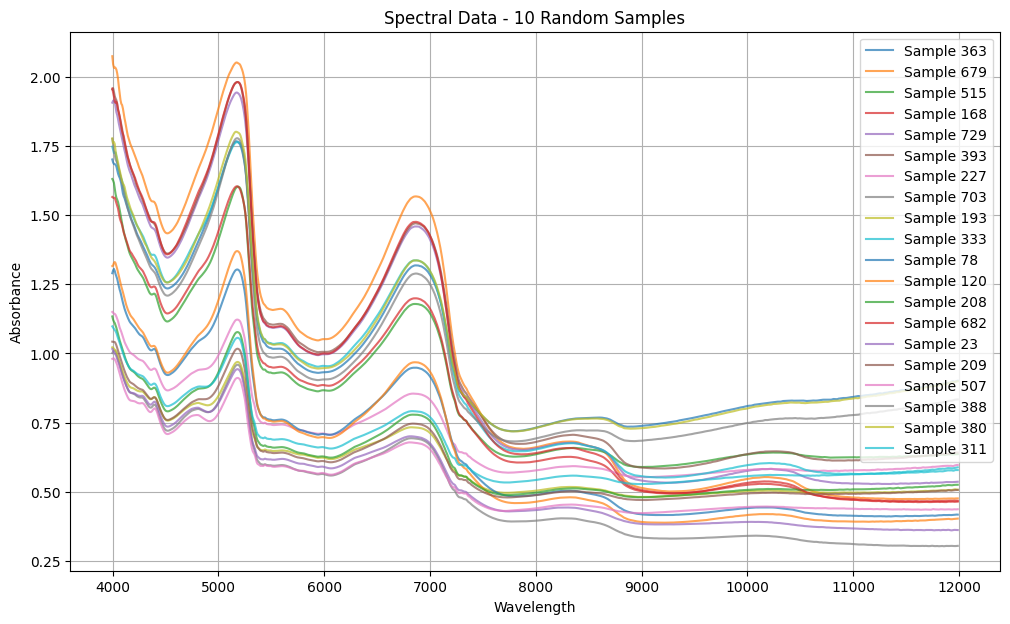

In [21]:
# Select 20 random samples
np.random.seed(42)
random_indices = np.random.choice(df.index, 20, replace=False)

plt.figure(figsize=(12, 7))
for idx in random_indices:
  raw_sample = df.iloc[idx, 2:-1]  # Exclude non-spectral columns
  plt.plot(raw_sample.index.astype(float), raw_sample.values, label=f'Sample {idx}', alpha=0.7)

plt.title('Spectral Data - 10 Random Samples')
plt.xlabel('Wavelength')
plt.ylabel('Absorbance')
plt.legend()
plt.grid(True)
plt.show()

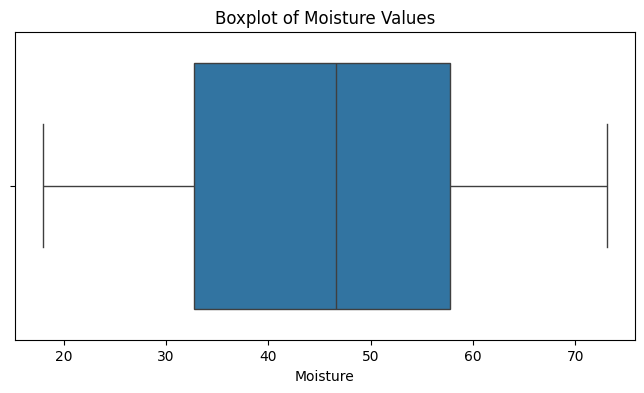

In [22]:
# Boxplot to visualize outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x='Moisture', data=df)
plt.title('Boxplot of Moisture Values')
plt.show()

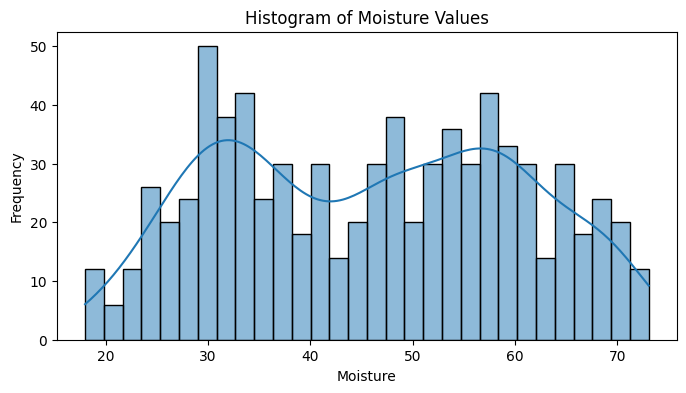

In [23]:
# Histogram to visualize distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['Moisture'], bins=30, kde=True)
plt.title('Histogram of Moisture Values')
plt.xlabel('Moisture')
plt.ylabel('Frequency')
plt.show()

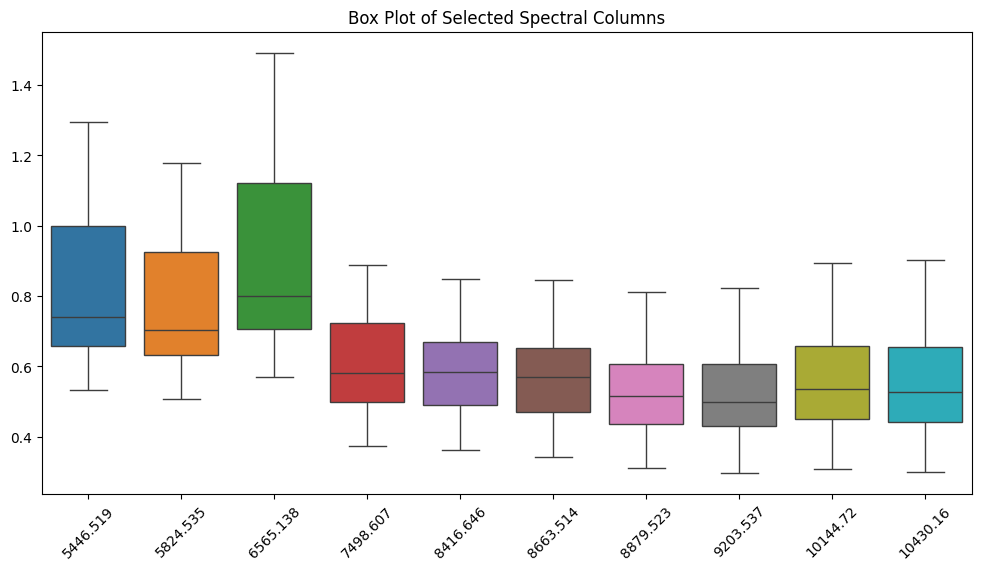

In [24]:
# Select 10 random spectral columns
spectral_columns = np.random.choice(df.columns[2:-1], 10, replace=False)

# Create box plots for these columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[spectral_columns])
plt.title('Box Plot of Selected Spectral Columns')
plt.xticks(rotation=45)
plt.show()

In [25]:
# Identify columns with outliers
outlier_columns = []

for col in df.select_dtypes(include='float'):
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1

  # Find outliers
  outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))]

  if not outliers.empty:
    outlier_columns.append(col)

if outlier_columns:
  print("Columns with outliers:", outlier_columns)
else:
  print("No columns with outliers found.")

No columns with outliers found.


# Data Preprocessing

## Savitzky-Golay

In [26]:
df_sg = df.copy()

# Apply Savitzky-Golay filter only to the spectral data
spectral_data = df.iloc[:, 2:-1].values  # Extract spectral data
filtered_data = savgol_filter(spectral_data, window_length=21, polyorder=2, axis=0)

# Assign filtered data back to the DataFrame
df_sg.iloc[:, 2:-1] = filtered_data

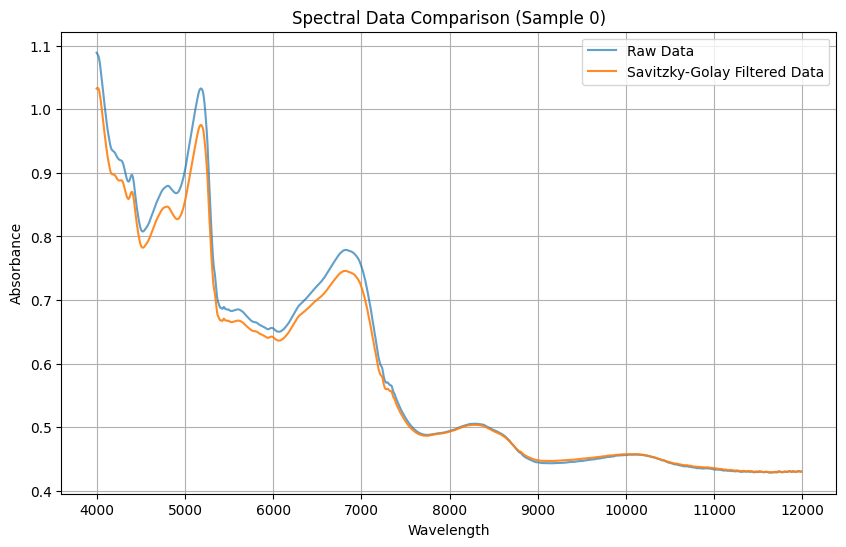

In [27]:
# Visualize the first row
sample_index = 0
raw_sample = df.iloc[sample_index, 2:-1]  # Exclude non-spectral columns
sg_sample = df_sg.iloc[sample_index, 2:-1]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(raw_sample.index, raw_sample.values, label='Raw Data', alpha=0.7)
plt.plot(sg_sample.index, sg_sample.values, label='Savitzky-Golay Filtered Data', alpha=0.9)
plt.title(f'Spectral Data Comparison (Sample {sample_index})')
plt.xlabel('Wavelength')
plt.ylabel('Absorbance')
plt.legend()
plt.grid(True)
plt.show()

## Standard Normal Variate (SVN)

In [28]:
# Apply SNV
df_snv = df.copy()
df_snv.iloc[:, 2:-1] = snv(df.iloc[:, 2:-1].values)

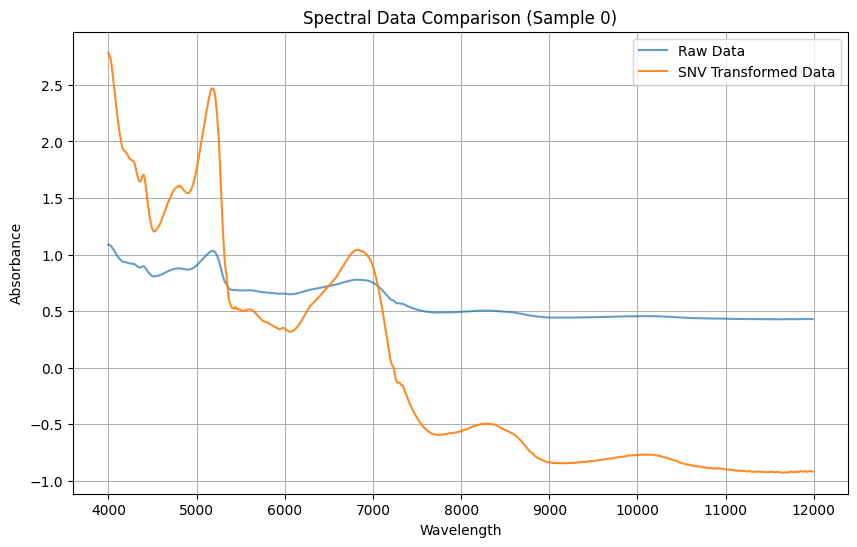

In [29]:
# Visualize the first row
sample_index = 0
raw_sample = df.iloc[sample_index, 2:-1]
snv_sample = df_snv.iloc[sample_index, 2:-1]

plt.figure(figsize=(10, 6))
plt.plot(raw_sample.index.astype(float), raw_sample.values, label='Raw Data', alpha=0.7)
plt.plot(snv_sample.index.astype(float), snv_sample.values, label='SNV Transformed Data', alpha=0.9)
plt.title(f'Spectral Data Comparison (Sample {sample_index})')
plt.xlabel('Wavelength')
plt.ylabel('Absorbance')
plt.legend()
plt.grid(True)
plt.show()

## Multiplicative Scatter Correction (MSC)

In [30]:
df_msc = df.copy()

# Apply MSC
spectral_data = df.iloc[:, 2:-1].values  # Extract spectral data
corrected_data = msc(spectral_data)

# Assign MSC corrected data back to the DataFrame
df_msc.iloc[:, 2:-1] = corrected_data

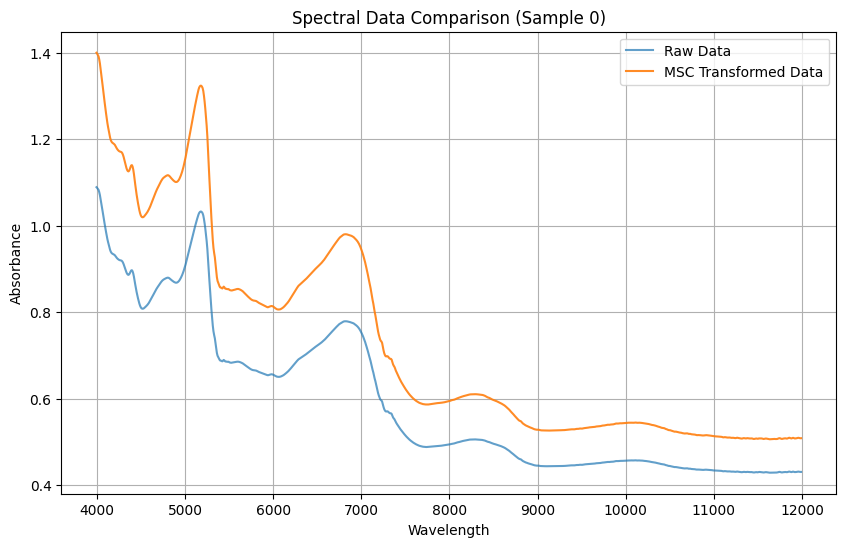

In [31]:
# Visualize the first row
sample_index = 0
raw_sample = df.iloc[sample_index, 2:-1]   # Raw data
msc_sample = df_msc.iloc[sample_index, 2:-1]  # MSC transformed data

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(raw_sample.index.astype(float), raw_sample.values, label='Raw Data', alpha=0.7)
plt.plot(msc_sample.index.astype(float), msc_sample.values, label='MSC Transformed Data', alpha=0.9)
plt.title(f'Spectral Data Comparison (Sample {sample_index})')
plt.xlabel('Wavelength')
plt.ylabel('Absorbance')
plt.legend()
plt.grid(True)
plt.show()

## Comparison

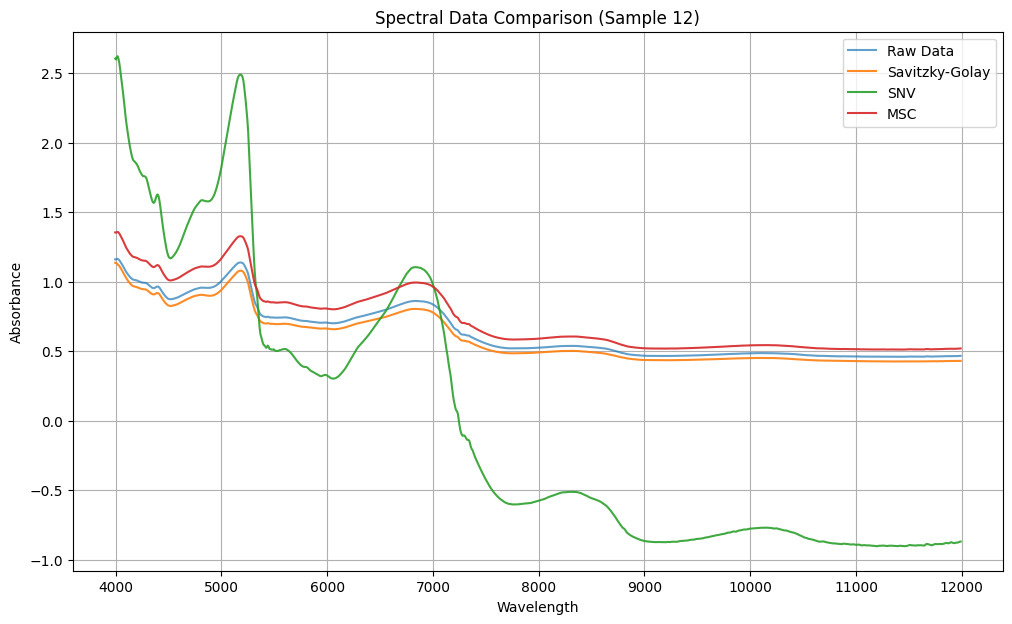

In [32]:
# Select a random row (12)
sample_index = 12
raw_sample = df.iloc[sample_index, 2:-1] # Raw
sg_sample = df_sg.iloc[sample_index, 2:-1] # Savitzky-Golay
snv_sample = df_snv.iloc[sample_index, 2:-1] # SVN
msc_sample = df_msc.iloc[sample_index, 2:-1] # MSC

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(raw_sample.index.astype(float), raw_sample.values, label='Raw Data', alpha=0.7)
plt.plot(sg_sample.index.astype(float), sg_sample.values, label='Savitzky-Golay', alpha=0.9)
plt.plot(snv_sample.index.astype(float), snv_sample.values, label='SNV', alpha=0.9)
plt.plot(msc_sample.index.astype(float), msc_sample.values, label='MSC', alpha=0.9)

plt.title(f'Spectral Data Comparison (Sample {sample_index})')
plt.xlabel('Wavelength')
plt.ylabel('Absorbance')
plt.legend()
plt.grid(True)
plt.show()

# Modeling

## Train-test Splitting

In [33]:
# Perform train-test split for each dataset
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split_data(df, 'Raw Data')
X_train_sg, X_test_sg, y_train_sg, y_test_sg = train_test_split_data(df_sg, 'Savitzky-Golay Data')
X_train_snv, X_test_snv, y_train_snv, y_test_snv = train_test_split_data(df_snv, 'SNV Data')
X_train_msc, X_test_msc, y_train_msc, y_test_msc = train_test_split_data(df_msc, 'MSC Data')

Raw Data:
  Train Shape: X_train (618, 1037), y_train (618,)
  Test Shape: X_test (155, 1037), y_test (155,)
----------------------------------------
Savitzky-Golay Data:
  Train Shape: X_train (618, 1037), y_train (618,)
  Test Shape: X_test (155, 1037), y_test (155,)
----------------------------------------
SNV Data:
  Train Shape: X_train (618, 1037), y_train (618,)
  Test Shape: X_test (155, 1037), y_test (155,)
----------------------------------------
MSC Data:
  Train Shape: X_train (618, 1037), y_train (618,)
  Test Shape: X_test (155, 1037), y_test (155,)
----------------------------------------


## Partial Least Squares (PLS)

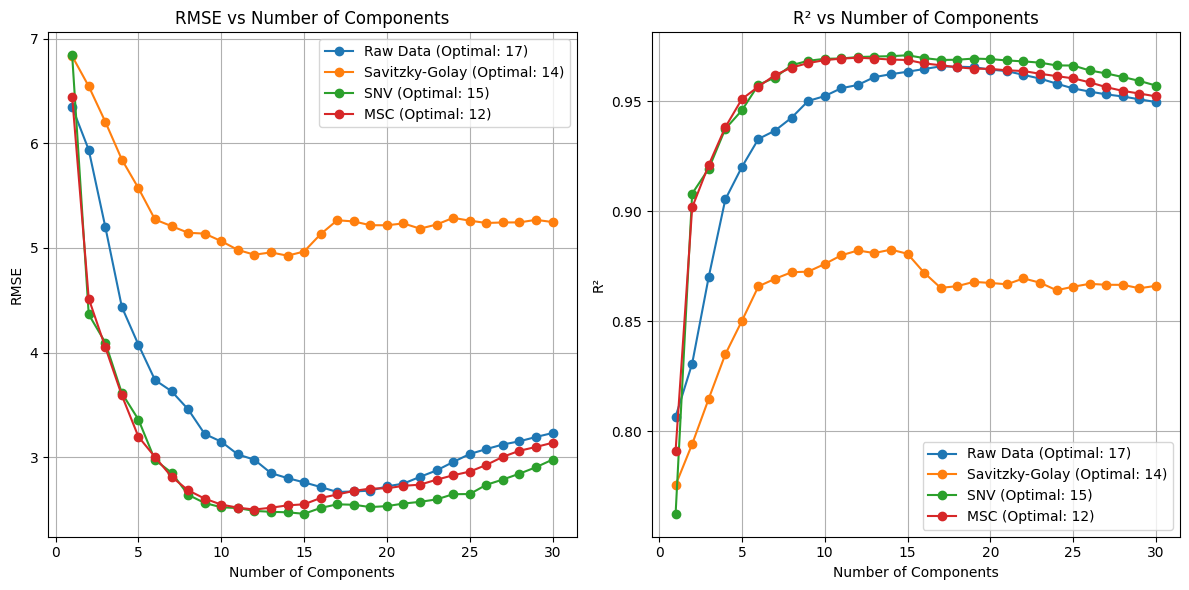

In [34]:
# Perform CV for each dataset
rmse_raw, r2_raw, optimal_rmse_raw, optimal_r2_raw = cross_validate_pls(X_train_raw, y_train_raw)
rmse_sg, r2_sg, optimal_rmse_sg, optimal_r2_sg = cross_validate_pls(X_train_sg, y_train_sg)
rmse_snv, r2_snv, optimal_rmse_snv, optimal_r2_snv = cross_validate_pls(X_train_snv, y_train_snv)
rmse_msc, r2_msc, optimal_rmse_msc, optimal_r2_msc = cross_validate_pls(X_train_msc, y_train_msc)

# RMSE Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 31), rmse_raw, label=f'Raw Data (Optimal: {optimal_rmse_raw})', marker='o')
plt.plot(range(1, 31), rmse_sg, label=f'Savitzky-Golay (Optimal: {optimal_rmse_sg})', marker='o')
plt.plot(range(1, 31), rmse_snv, label=f'SNV (Optimal: {optimal_rmse_snv})', marker='o')
plt.plot(range(1, 31), rmse_msc, label=f'MSC (Optimal: {optimal_rmse_msc})', marker='o')
plt.title('RMSE vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

# R² Visualization
plt.subplot(1, 2, 2)
plt.plot(range(1, 31), r2_raw, label=f'Raw Data (Optimal: {optimal_r2_raw})', marker='o')
plt.plot(range(1, 31), r2_sg, label=f'Savitzky-Golay (Optimal: {optimal_r2_sg})', marker='o')
plt.plot(range(1, 31), r2_snv, label=f'SNV (Optimal: {optimal_r2_snv})', marker='o')
plt.plot(range(1, 31), r2_msc, label=f'MSC (Optimal: {optimal_r2_msc})', marker='o')
plt.title('R² vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('R²')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [35]:
# Train and evaluate for each dataset (using new variable names)
results_pls = {}

results_pls['Raw'] = train_evaluate_pls(X_train_raw, y_train_raw, X_test_raw, y_test_raw, optimal_rmse_raw)
results_pls['Savitzky-Golay'] = train_evaluate_pls(X_train_sg, y_train_sg, X_test_sg, y_test_sg, optimal_rmse_sg)
results_pls['SNV'] = train_evaluate_pls(X_train_snv, y_train_snv, X_test_snv, y_test_snv, optimal_rmse_snv)
results_pls['MSC'] = train_evaluate_pls(X_train_msc, y_train_msc, X_test_msc, y_test_msc, optimal_rmse_msc)

# Display Results
for key, value in results_pls.items():
  print(f"{key} Data:")
  print(f"  Train RMSE: {value[0]:.4f}, Test RMSE: {value[1]:.4f}")
  print(f"  Train R²: {value[2]:.4f}, Test R²: {value[3]:.4f}")
  print('-' * 40)

Raw Data:
  Train RMSE: 2.3396, Test RMSE: 2.5669
  Train R²: 0.9739, Test R²: 0.9675
----------------------------------------
Savitzky-Golay Data:
  Train RMSE: 4.6199, Test RMSE: 4.5300
  Train R²: 0.8982, Test R²: 0.8987
----------------------------------------
SNV Data:
  Train RMSE: 2.1323, Test RMSE: 2.1282
  Train R²: 0.9783, Test R²: 0.9776
----------------------------------------
MSC Data:
  Train RMSE: 2.2700, Test RMSE: 2.2147
  Train R²: 0.9754, Test R²: 0.9758
----------------------------------------


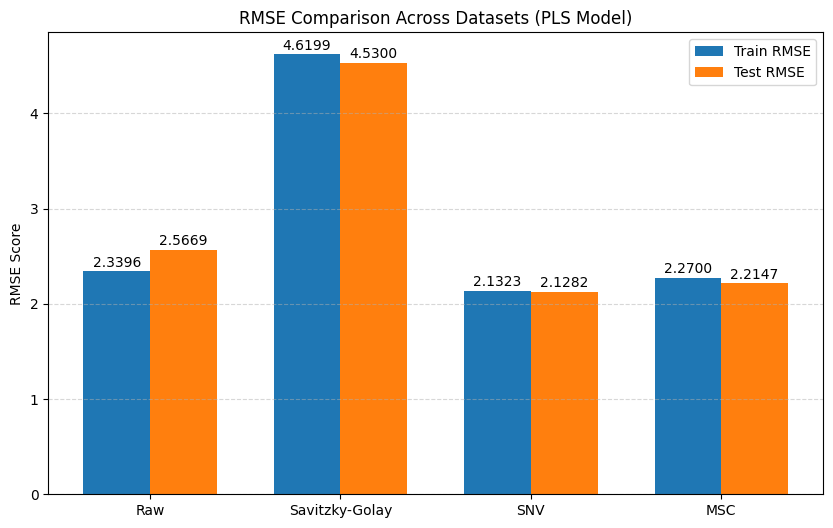

In [36]:
# Extracting results for visualization
datasets = list(results_pls.keys())
train_rmse_values = [results_pls[dataset][0] for dataset in datasets]
test_rmse_values = [results_pls[dataset][1] for dataset in datasets]

# Plotting
x = np.arange(len(datasets))  # Dataset labels
width = 0.35  # Bar width

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, train_rmse_values, width, label='Train RMSE')
plt.bar(x + width/2, test_rmse_values, width, label='Test RMSE')

# Adding labels and details
plt.xticks(x, datasets)
plt.title('RMSE Comparison Across Datasets (PLS Model)')
plt.ylabel('RMSE Score')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Display the values on top of each bar (4 decimal precision)
for i, (train, test) in enumerate(zip(train_rmse_values, test_rmse_values)):
  plt.text(i - width/2, train + 0.05, f"{train:.4f}", ha='center')
  plt.text(i + width/2, test + 0.05, f"{test:.4f}", ha='center')

plt.show()

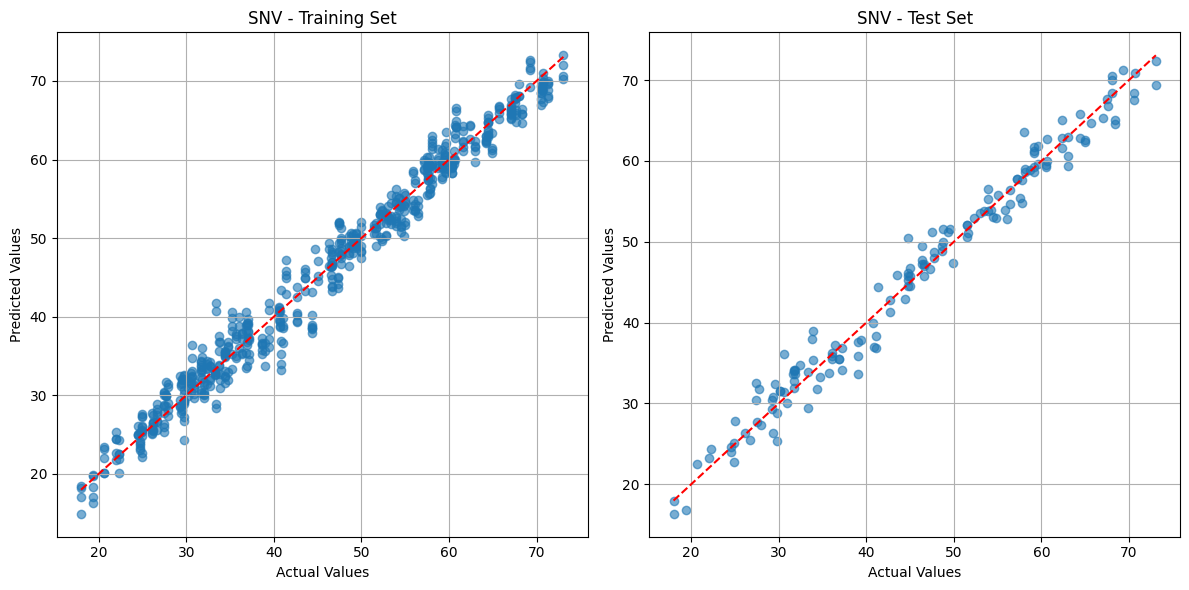

In [37]:
# Identify the best-performing model
best_model = min(results_pls, key=lambda x: results_pls[x][1])  # Based on Test RMSE

# Train the best-performing model to obtain predictions
optimal_components = locals()[f'optimal_rmse_{best_model.lower()}']
pls = PLSRegression(n_components=optimal_components)
pls.fit(locals()[f'X_train_{best_model.lower()}'], locals()[f'y_train_{best_model.lower()}'])

y_train_pred = pls.predict(locals()[f'X_train_{best_model.lower()}'])
y_test_pred = pls.predict(locals()[f'X_test_{best_model.lower()}'])

# Visualize Predictions
visualize_predictions(
  locals()[f'y_train_{best_model.lower()}'], y_train_pred,
  locals()[f'y_test_{best_model.lower()}'], y_test_pred,
  best_model
)

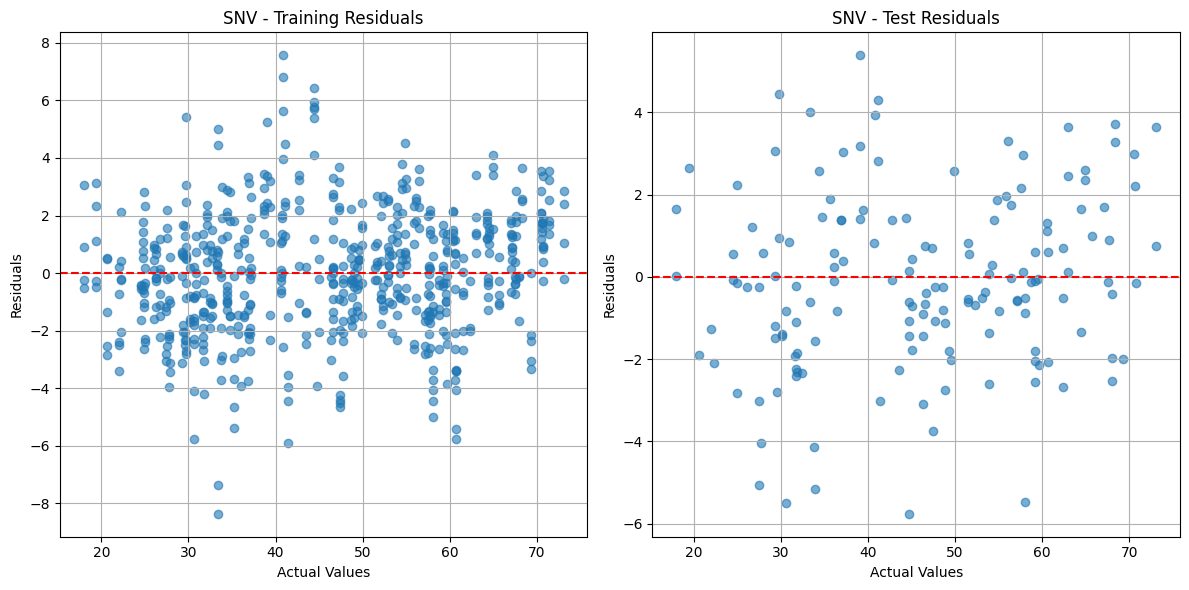

In [38]:
# Perform residual analysis for the best model
visualize_residuals(
  locals()[f'y_train_{best_model.lower()}'], y_train_pred,
  locals()[f'y_test_{best_model.lower()}'], y_test_pred,
  best_model
)

##Support Vector Regression (SVR)

In [39]:
# Tune SVR for each dataset
optimal_params = {}
optimal_rmse = {}

optimal_params['Raw'], optimal_rmse['Raw'] = svr_cv(X_train_raw, y_train_raw)
optimal_params['Savitzky-Golay'], optimal_rmse['Savitzky-Golay'] = svr_cv(X_train_sg, y_train_sg)
optimal_params['SNV'], optimal_rmse['SNV'] = svr_cv(X_train_snv, y_train_snv)
optimal_params['MSC'], optimal_rmse['MSC'] = svr_cv(X_train_msc, y_train_msc)

# Display results
for key, value in optimal_params.items():
  print(f"{key} Data:")
  print(f"  Best Params: {value}")
  print(f"  Best CV RMSE: {optimal_rmse[key]:.4f}")
  print('-' * 40)

Raw Data:
  Best Params: {'C': 100, 'epsilon': 0.5, 'kernel': 'linear'}
  Best CV RMSE: 3.3602
----------------------------------------
Savitzky-Golay Data:
  Best Params: {'C': 100, 'epsilon': 0.5, 'kernel': 'linear'}
  Best CV RMSE: 5.1625
----------------------------------------
SNV Data:
  Best Params: {'C': 100, 'epsilon': 0.5, 'kernel': 'linear'}
  Best CV RMSE: 2.3953
----------------------------------------
MSC Data:
  Best Params: {'C': 100, 'epsilon': 0.5, 'kernel': 'linear'}
  Best CV RMSE: 2.6520
----------------------------------------


In [40]:
# Train and evaluate for each dataset
results_svr = {}
y_train_preds = {}
y_test_preds = {}

dataset_map = {
  'Raw': 'raw',
  'Savitzky-Golay': 'sg',
  'SNV': 'snv',
  'MSC': 'msc'
}

for key in optimal_params.keys():
  mapped_key = dataset_map[key]
  results_svr[key] = train_evaluate_svr(
    locals()[f'X_train_{mapped_key}'],
    locals()[f'y_train_{mapped_key}'],
    locals()[f'X_test_{mapped_key}'],
    locals()[f'y_test_{mapped_key}'],
    optimal_params[key]
  )

  # Save predictions for visualization
  y_train_preds[key] = results_svr[key][4]
  y_test_preds[key] = results_svr[key][5]

# Display Results
for key, value in results_svr.items():
  print(f"{key} Data:")
  print(f"  Train RMSE: {value[0]:.4f}, Test RMSE: {value[1]:.4f}")
  print(f"  Train R²: {value[2]:.4f}, Test R²: {value[3]:.4f}")
  print('-' * 40)

Raw Data:
  Train RMSE: 3.2281, Test RMSE: 3.3868
  Train R²: 0.9503, Test R²: 0.9434
----------------------------------------
Savitzky-Golay Data:
  Train RMSE: 5.0297, Test RMSE: 4.9202
  Train R²: 0.8793, Test R²: 0.8805
----------------------------------------
SNV Data:
  Train RMSE: 2.1538, Test RMSE: 2.2516
  Train R²: 0.9779, Test R²: 0.9750
----------------------------------------
MSC Data:
  Train RMSE: 2.5467, Test RMSE: 2.6909
  Train R²: 0.9691, Test R²: 0.9643
----------------------------------------


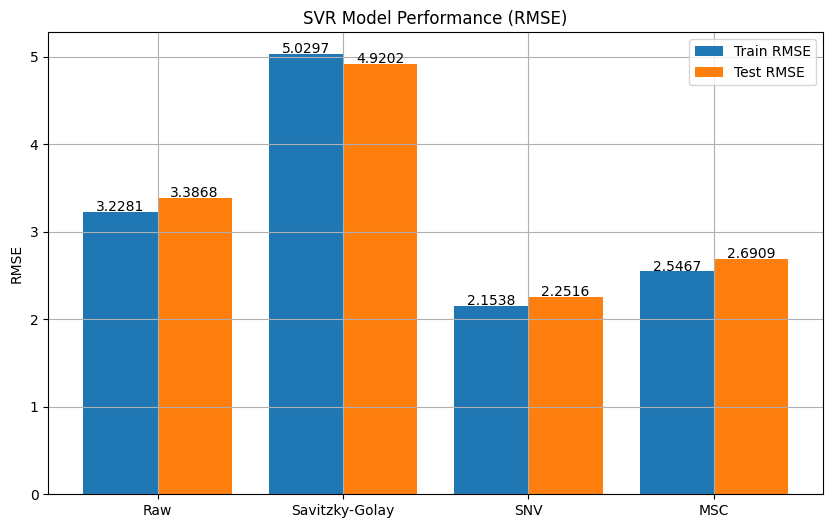

In [41]:
# Visualizing RMSE for Each Dataset
datasets = list(results_svr.keys())
train_rmse_values = [round(results_svr[key][0], 4) for key in datasets]
test_rmse_values = [round(results_svr[key][1], 4) for key in datasets]

x = np.arange(len(datasets))

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - 0.2, train_rmse_values, width=0.4, label='Train RMSE')
bars2 = plt.bar(x + 0.2, test_rmse_values, width=0.4, label='Test RMSE')

# Annotate values on top of bars
for bar in bars1:
  plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.4f}', ha='center')

for bar in bars2:
  plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.4f}', ha='center')

plt.xticks(x, datasets)
plt.ylabel('RMSE')
plt.title('SVR Model Performance (RMSE)')
plt.legend()
plt.grid(True)
plt.show()

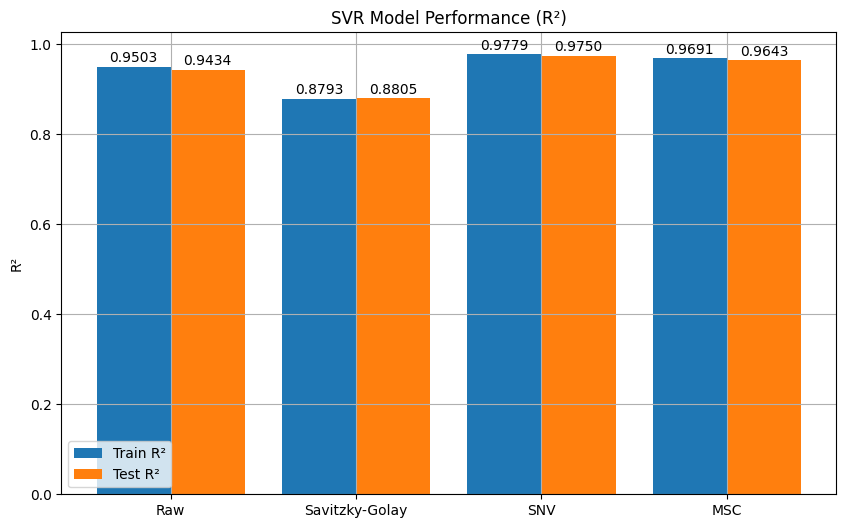

In [42]:
# Visualizing R² for Each Dataset
datasets = list(results_svr.keys())
train_r2_values = [round(results_svr[key][2], 4) for key in datasets]  # R² values for train set
test_r2_values = [round(results_svr[key][3], 4) for key in datasets]  # R² values for test set

x = np.arange(len(datasets))

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - 0.2, train_r2_values, width=0.4, label='Train R²')
bars2 = plt.bar(x + 0.2, test_r2_values, width=0.4, label='Test R²')

# Annotate values on top of bars
for bar in bars1:
  plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.4f}', ha='center')

for bar in bars2:
  plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.4f}', ha='center')

plt.xticks(x, datasets)
plt.ylabel('R²')
plt.title('SVR Model Performance (R²)')
plt.legend()
plt.grid(True)
plt.show()

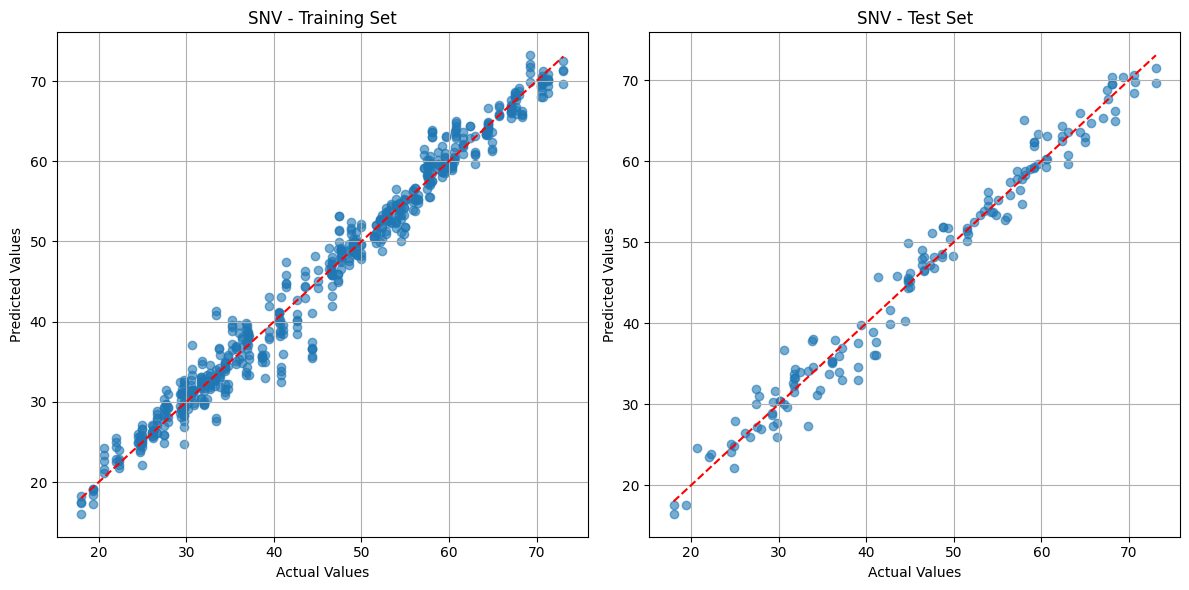

In [43]:
# Identify best SVR model based on Test RMSE
best_svr_model = min(results_svr, key=lambda x: results_svr[x][1])

# Visualize Predictions
visualize_predictions(
  locals()[f'y_train_{best_svr_model.lower()}'],
  y_train_preds[best_svr_model],
  locals()[f'y_test_{best_svr_model.lower()}'],
  y_test_preds[best_svr_model],
  best_svr_model
)

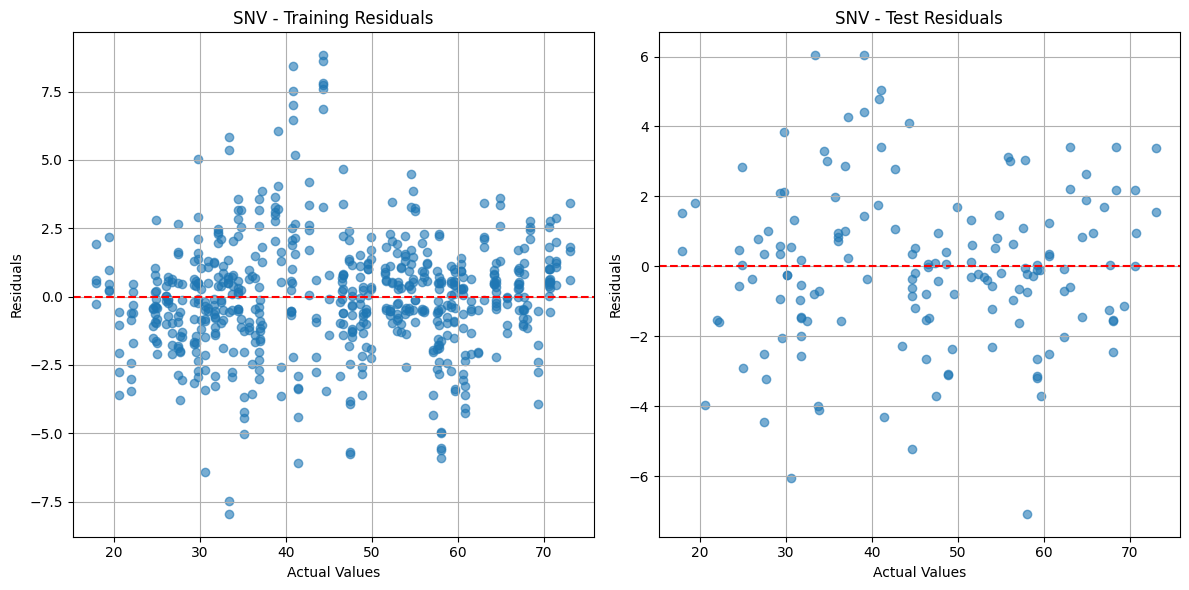

In [44]:
# Visualize Residual Analysis
visualize_residuals(
  locals()[f'y_train_{best_svr_model.lower()}'],
  y_train_preds[best_svr_model],
  locals()[f'y_test_{best_svr_model.lower()}'],
  y_test_preds[best_svr_model],
  best_svr_model
)

## Artificial Neural Network (ANN)

In [45]:
# Training for each dataset
results = {}

# Raw Data
ann_model_raw = build_ann(X_train_raw.shape[1])
history_raw = train_ann(ann_model_raw, X_train_raw, y_train_raw, X_test_raw, y_test_raw)

results['Raw'] = history_raw

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1442.9443 - mean_squared_error: 1442.9443 - val_loss: 58.7846 - val_mean_squared_error: 58.7846
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 78.3194 - mean_squared_error: 78.3194 - val_loss: 47.5628 - val_mean_squared_error: 47.5628
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 49.2120 - mean_squared_error: 49.2120 - val_loss: 46.6294 - val_mean_squared_error: 46.6294
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 43.2618 - mean_squared_error: 43.2618 - val_loss: 45.0870 - val_mean_squared_error: 45.0870
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 43.9838 - mean_squared_error: 43.9838 - val_loss: 44.7134 - val_mean_squared_error: 44.7134
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 45.8879 - mean_squared_error: 45.8879 - val_loss: 44.2681 - val_mean_squared_error: 44.2681
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 43.9737 - mean_squared_error: 43.973

In [46]:
# Savitzky-Golay Data
ann_model_sg = build_ann(X_train_sg.shape[1])
history_sg = train_ann(ann_model_sg, X_train_sg, y_train_sg, X_test_sg, y_test_sg)

results['Savitzky-Golay'] = history_sg

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1773.6155 - mean_squared_error: 1773.6155 - val_loss: 184.3106 - val_mean_squared_error: 184.3106
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 105.5470 - mean_squared_error: 105.5470 - val_loss: 66.8842 - val_mean_squared_error: 66.8842
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 58.0252 - mean_squared_error: 58.0252 - val_loss: 53.5397 - val_mean_squared_error: 53.5397
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 56.2343 - mean_squared_error: 56.2343 - val_loss: 51.8905 - val_mean_squared_error: 51.8905
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 55.1382 - mean_squared_error: 55.1382 - val_loss: 51.6696 - val_mean_squared_error: 51.6696
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 50.5960 - mean_squared_error: 50.5960 - val_loss: 51.2956 - val_mean_squared_error: 51.2956
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 54.9463 - mean_squared_err

In [47]:
# SNV Data
ann_model_snv = build_ann(X_train_snv.shape[1])
history_snv = train_ann(ann_model_snv, X_train_snv, y_train_snv, X_test_snv, y_test_snv)

results['SNV'] = history_snv

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1192.3937 - mean_squared_error: 1192.3937 - val_loss: 384.6622 - val_mean_squared_error: 384.6622
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 326.4776 - mean_squared_error: 326.4776 - val_loss: 229.3706 - val_mean_squared_error: 229.3706
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 219.3752 - mean_squared_error: 219.3752 - val_loss: 185.4321 - val_mean_squared_error: 185.4321
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 185.2324 - mean_squared_error: 185.2324 - val_loss: 169.3535 - val_mean_squared_error: 169.3535
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 181.9387 - mean_squared_error: 181.9387 - val_loss: 158.0713 - val_mean_squared_error: 158.0713
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 166.5602 - mean_squared_error: 166.5602 - val_loss: 145.1566 - val_mean_squared_error: 145.1566
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 144.4350

In [48]:
# MSC Data
ann_model_msc = build_ann(X_train_msc.shape[1])
history_msc = train_ann(ann_model_msc, X_train_msc, y_train_msc, X_test_msc, y_test_msc)

results['MSC'] = history_msc

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1680.1719 - mean_squared_error: 1680.1719 - val_loss: 211.0822 - val_mean_squared_error: 211.0822
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 237.2197 - mean_squared_error: 237.2197 - val_loss: 203.8014 - val_mean_squared_error: 203.8014
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 211.4617 - mean_squared_error: 211.4617 - val_loss: 203.1788 - val_mean_squared_error: 203.1788
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 213.3875 - mean_squared_error: 213.3875 - val_loss: 201.9377 - val_mean_squared_error: 201.9377
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 197.7086 - mean_squared_error: 197.7086 - val_loss: 201.7512 - val_mean_squared_error: 201.7512
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 201.1945 - mean_squared_error: 201.1945 - val_loss: 200.7194 - val_mean_squared_error: 200.7194
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 214.9659

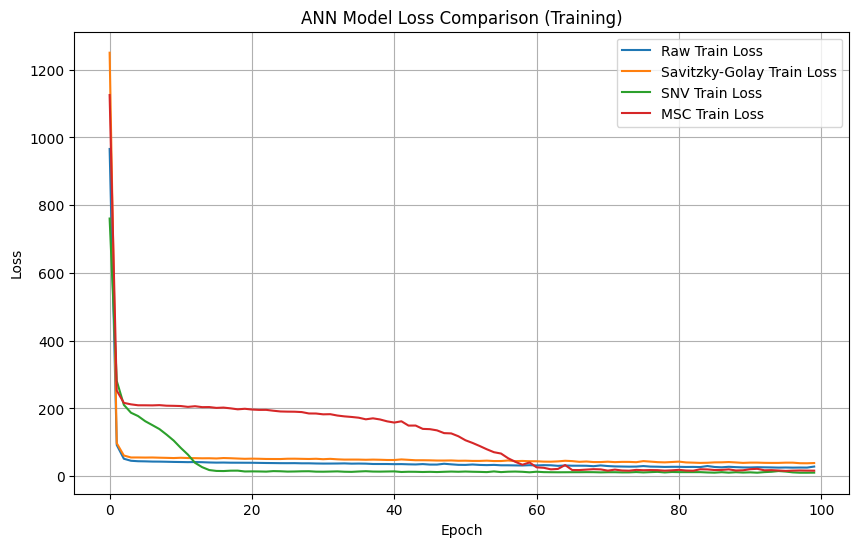

In [49]:
# Visualize Training Loss for all datasets
plt.figure(figsize=(10, 6))
for key in results.keys():
  plt.plot(results[key].history['loss'], label=f'{key} Train Loss')

plt.title('ANN Model Loss Comparison (Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# Initialize dictionary to store results
evaluation_results = {}

# Raw Data Model Evaluation
y_train_raw_pred = ann_model_raw.predict(X_train_raw)
y_test_raw_pred = ann_model_raw.predict(X_test_raw)
train_rmse_raw, train_r2_raw = calculate_metrics(y_train_raw, y_train_raw_pred)
test_rmse_raw, test_r2_raw = calculate_metrics(y_test_raw, y_test_raw_pred)

# Savitzky-Golay Model Evaluation
y_train_sg_pred = ann_model_sg.predict(X_train_sg)
y_test_sg_pred = ann_model_sg.predict(X_test_sg)
train_rmse_sg, train_r2_sg = calculate_metrics(y_train_sg, y_train_sg_pred)
test_rmse_sg, test_r2_sg = calculate_metrics(y_test_sg, y_test_sg_pred)

# SNV Model Evaluation
y_train_snv_pred = ann_model_snv.predict(X_train_snv)
y_test_snv_pred = ann_model_snv.predict(X_test_snv)
train_rmse_snv, train_r2_snv = calculate_metrics(y_train_snv, y_train_snv_pred)
test_rmse_snv, test_r2_snv = calculate_metrics(y_test_snv, y_test_snv_pred)

# MSC Model Evaluation
y_train_msc_pred = ann_model_msc.predict(X_train_msc)
y_test_msc_pred = ann_model_msc.predict(X_test_msc)
train_rmse_msc, train_r2_msc = calculate_metrics(y_train_msc, y_train_msc_pred)
test_rmse_msc, test_r2_msc = calculate_metrics(y_test_msc, y_test_msc_pred)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [51]:
# Store Results
evaluation_results['Raw'] = {
    'Train RMSE': train_rmse_raw, 'Test RMSE': test_rmse_raw,
    'Train R²': train_r2_raw, 'Test R²': test_r2_raw
}
evaluation_results['Savitzky-Golay'] = {
    'Train RMSE': train_rmse_sg, 'Test RMSE': test_rmse_sg,
    'Train R²': train_r2_sg, 'Test R²': test_r2_sg
}
evaluation_results['SNV'] = {
    'Train RMSE': train_rmse_snv, 'Test RMSE': test_rmse_snv,
    'Train R²': train_r2_snv, 'Test R²': test_r2_snv
}
evaluation_results['MSC'] = {
    'Train RMSE': train_rmse_msc, 'Test RMSE': test_rmse_msc,
    'Train R²': train_r2_msc, 'Test R²': test_r2_msc
}

In [52]:
# Display the results with 4 decimal places
for model_name, metrics in evaluation_results.items():
  print(f"{model_name} Data:")
  print(f"  Train RMSE: {metrics['Train RMSE']:.4f}")
  print(f"  Test RMSE: {metrics['Test RMSE']:.4f}")
  print(f"  Train R²: {metrics['Train R²']:.4f}")
  print(f"  Test R²: {metrics['Test R²']:.4f}")
  print('-' * 40)

Raw Data:
  Train RMSE: 4.9847
  Test RMSE: 5.1717
  Train R²: 0.8815
  Test R²: 0.8680
----------------------------------------
Savitzky-Golay Data:
  Train RMSE: 6.1672
  Test RMSE: 5.9403
  Train R²: 0.8185
  Test R²: 0.8258
----------------------------------------
SNV Data:
  Train RMSE: 3.1763
  Test RMSE: 3.2822
  Train R²: 0.9519
  Test R²: 0.9468
----------------------------------------
MSC Data:
  Train RMSE: 3.9054
  Test RMSE: 4.0228
  Train R²: 0.9272
  Test R²: 0.9201
----------------------------------------


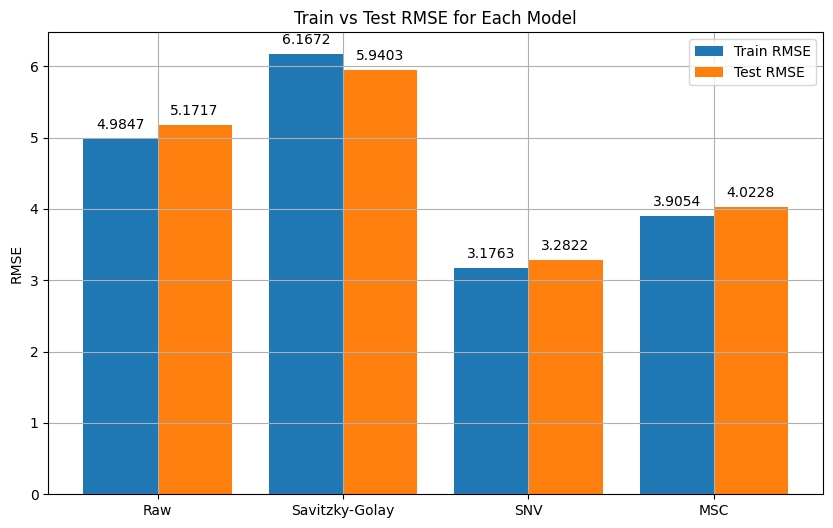

In [53]:
# Define the train and test RMSE for each model
train_rmse_values = [evaluation_results[model]['Train RMSE'] for model in evaluation_results]
test_rmse_values = [evaluation_results[model]['Test RMSE'] for model in evaluation_results]

# Model names for labels
models = list(evaluation_results.keys())

# Create the x-axis positions
x = np.arange(len(models))

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, train_rmse_values, width=0.4, label='Train RMSE')
plt.bar(x + 0.2, test_rmse_values, width=0.4, label='Test RMSE')

# Customize the plot
plt.xticks(x, models)
plt.ylabel('RMSE')
plt.title('Train vs Test RMSE for Each Model')
plt.legend()
plt.grid(True)

# Display the RMSE values on top of the bars
for i, (train_rmse, test_rmse) in enumerate(zip(train_rmse_values, test_rmse_values)):
  plt.text(x[i] - 0.2, train_rmse + 0.1, f'{train_rmse:.4f}', ha='center', va='bottom')
  plt.text(x[i] + 0.2, test_rmse + 0.1, f'{test_rmse:.4f}', ha='center', va='bottom')

plt.show()

## Final Comparison

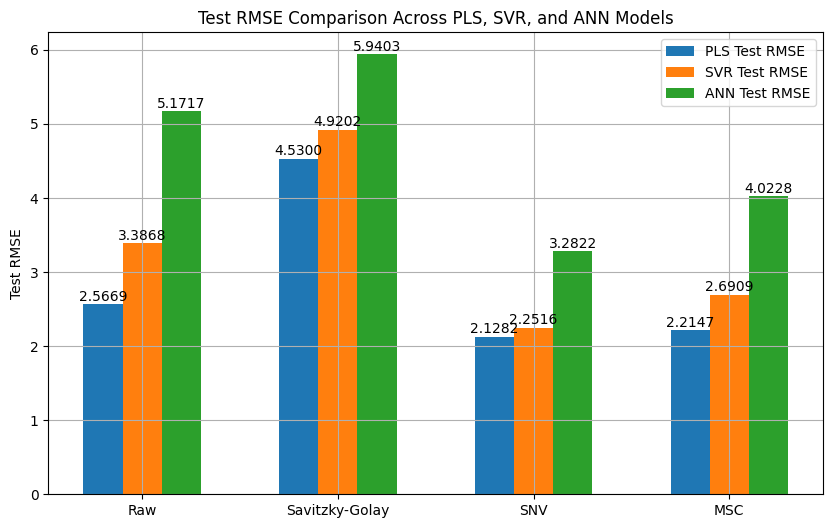

In [54]:
test_rmse_pls = [value[1] for value in results_pls.values()]
test_rmse_svr = [value[1] for value in results_svr.values()]
test_rmse_ann = test_rmse_values

# Define datasets
datasets = ['Raw', 'Savitzky-Golay', 'SNV', 'MSC']
x = np.arange(len(datasets))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, test_rmse_pls, width=0.2, label='PLS Test RMSE')
plt.bar(x, test_rmse_svr, width=0.2, label='SVR Test RMSE')
plt.bar(x + 0.2, test_rmse_ann, width=0.2, label='ANN Test RMSE')

# Adding labels and details
plt.xticks(x, datasets)
plt.title('Test RMSE Comparison Across PLS, SVR, and ANN Models')
plt.ylabel('Test RMSE')
plt.legend()
plt.grid(True)

# Display the values on top of each bar (4 decimal precision)
for i, (pls, svr, ann) in enumerate(zip(test_rmse_pls, test_rmse_svr, test_rmse_ann)):
  plt.text(i - 0.2, pls + 0.05, f"{pls:.4f}", ha='center')
  plt.text(i, svr + 0.05, f"{svr:.4f}", ha='center')
  plt.text(i + 0.2, ann + 0.05, f"{ann:.4f}", ha='center')

plt.show()

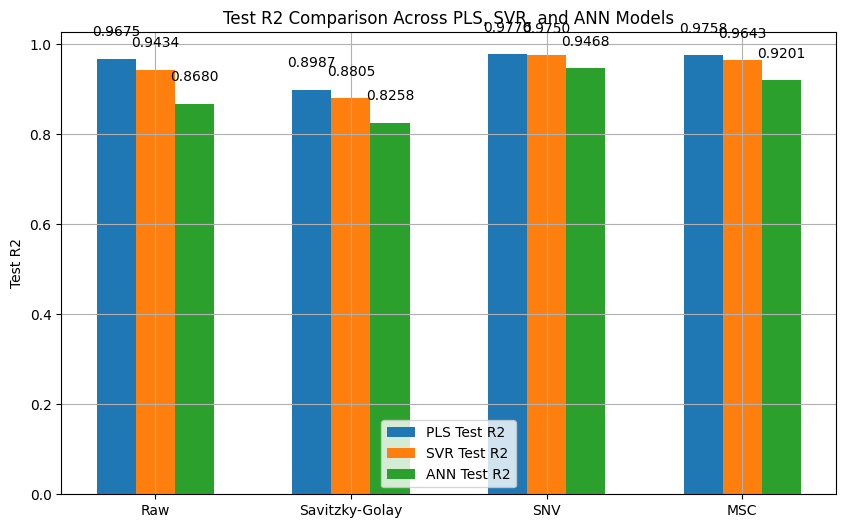

In [55]:
test_r2_pls = [value[3] for value in results_pls.values()]
test_r2_svr = [value[3] for value in results_svr.values()]
test_r2_ann = [evaluation_results[model]['Test R²'] for model in evaluation_results]

# Define datasets
datasets = ['Raw', 'Savitzky-Golay', 'SNV', 'MSC']
x = np.arange(len(datasets))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, test_r2_pls, width=0.2, label='PLS Test R2')
plt.bar(x, test_r2_svr, width=0.2, label='SVR Test R2')
plt.bar(x + 0.2, test_r2_ann, width=0.2, label='ANN Test R2')

# Adding labels and details
plt.xticks(x, datasets)
plt.title('Test R2 Comparison Across PLS, SVR, and ANN Models')
plt.ylabel('Test R2')
plt.legend()
plt.grid(True)

# Display the values on top of each bar (4 decimal precision)
for i, (pls, svr, ann) in enumerate(zip(test_r2_pls, test_r2_svr, test_r2_ann)):
  plt.text(i - 0.2, pls + 0.05, f"{pls:.4f}", ha='center')
  plt.text(i, svr + 0.05, f"{svr:.4f}", ha='center')
  plt.text(i + 0.2, ann + 0.05, f"{ann:.4f}", ha='center')

plt.show()